# Table of Contents:
[Data Cleaning](#cleaning)

[About the Participants](#participants)

[Backward Stepwise Selection](#backward)

## Data Cleaning <a name="cleaning"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
import duckdb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import accuracy_score

Firstly, load the data. The data set is wide and long, with 8378 rows and 195 columns.

In [2]:
dating_df = pd.read_csv("speed_dating_data.csv", encoding="ISO-8859-1")
dating_df.shape

(8378, 195)

### Select necessary columns
The data set has so many variables, so we went through the codebook made by the creators of this data set and selected variables we thought would be necessary for our future analysis. Now we still have 17 columns. 

Certainly, we won't use all of them at once in a logistic regression model. For example, demographic information about the participants such as "race" and "field_cd" will be mainly used in descriptive statistics for us to know about the subject population and detect sampling bias of the study rather than using them as explanatory variables in the model.

In [3]:
select_list = ['iid', 'gender', 'wave', 'round', 'pid',
               'age', 'field_cd', 'race','career_c', 'prob', 
               'dec', 'attr', 'sinc','intel', 'fun', 'amb', 'shar']

dating_df = dating_df[select_list]
dating_df.shape

(8378, 17)

### Rename columns

Though we did not do any web scraping or merge data sets to get this data frame, one main effort we made was to interpret the meaning of each variable – carefully reading through the 15-paged codebook. We noticed that some of the given variable names were vague. So, we decided to change them to more straightforward ones. 

In [4]:
dating_df = dating_df.rename(columns = {"iid": "id",
                                        "gender": "gender_cd",
                                        "round": "num_dates", 
                                        "pid": "partner_id", 
                                        "race": "race_cd",
                                        "career_c": "career_cd",
                                        "dec": "decision",
                                        "attr": "rate_p_attr",
                                        "sinc": "rate_p_sinc",
                                        "fun": "rate_p_fun",
                                        "intel": "rate_p_intel",
                                        "amb": "rate_p_amb",
                                        "shar": "rate_p_shar"})
# "cd" means "coded"
dating_df.columns

Index(['id', 'gender_cd', 'wave', 'num_dates', 'partner_id', 'age', 'field_cd',
       'race_cd', 'career_cd', 'prob', 'decision', 'rate_p_attr',
       'rate_p_sinc', 'rate_p_intel', 'rate_p_fun', 'rate_p_amb',
       'rate_p_shar'],
      dtype='object')

### Remove biased observations
The researchers ran 21 speed dating sessions, or waves, in total. However, as they explained in their paper, they removed four sessions (waves 18-21) from the analysis "because they involved an experimental intervention where participants were asked to bring their favorite book. These four sessions were run specifically to study how decision weights and selectivity would be affected by an intervention designed to shift subjects’ attention away from superficial physical attributes. They are omitted so that the only experimental difference across sessions is group size." Accordingly, we also removed data for these four sessions. 

The researchers also said they removed wave 12 because they "imposed a maximum number of acceptances" on participants of this wave. We thought this restriction would affect participants' decisions, so we also removed this wave.

In [5]:
dating_df = dating_df[~dating_df['wave'].isin([12, 18, 19, 20, 21])]
dating_df.shape

(6412, 17)

### Deal with missing values
We noticed there were many missing values due to how the experiment was designed and conducted. For each variable with more than 200 missing values, we re-examined whether we still thought it would be a potential good predictor in our future modeling given that including it would mean fewer data points to train the model, which might make the model less robust. Finally, we decided to remove the variable called "rate_p_shar" (the dater's rating for shared interests/hobbies towards the datee).

In [6]:
# count NAs for each column
for col in dating_df:
    n = sum(pd.isna(dating_df[col]))
    if (n > 0):
        print(f"Number of missing values for {col}: {n}")

dating_df = dating_df.drop(['rate_p_shar'], axis=1)

Number of missing values for partner_id: 10
Number of missing values for age: 73
Number of missing values for field_cd: 82
Number of missing values for race_cd: 63
Number of missing values for career_cd: 138
Number of missing values for prob: 206
Number of missing values for rate_p_attr: 130
Number of missing values for rate_p_sinc: 196
Number of missing values for rate_p_intel: 208
Number of missing values for rate_p_fun: 260
Number of missing values for rate_p_amb: 553
Number of missing values for rate_p_shar: 874


Next, let's drop rows with any missing values.

In [7]:
dating_df = dating_df.dropna()
dating_df.shape

(5573, 16)

### Detect inaccurate observations

According to the variable codebook, variables such as rate_self_attr and rate_p_attr represent ratings on a scale of 1-10. It was necessary to check if this was really the case. We did not trust the data because the original dataset was not well-cleaned. As we did it ourselves, we did catch abnormal points.

In [8]:
for col in ['rate_p_attr', 'rate_p_sinc', 'rate_p_amb',
            'rate_p_intel', 'rate_p_fun', 'prob']:
    dating_df = dating_df[dating_df[col].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])]
dating_df.shape

(5500, 16)

From a statistical standpoint, a sample of 5500 observations would be good enough for logistic regression. We would also have enough for splitting it into training, validation, and test sets.

### Convert data types

We noticed the data types of some columns did not accurately reflect what they should be. For example, variables race_cd, field_cd, career_cd, and gender_cd should be of the type category. And age and partner_id should be of type int. Other numerical variables such as rate_p_attr represent ratings on a scale of 1-10, so they should also be integers.

In [9]:
data_types = dating_df.dtypes
print(data_types)

id                int64
gender_cd         int64
wave              int64
num_dates         int64
partner_id      float64
age             float64
field_cd        float64
race_cd         float64
career_cd       float64
prob            float64
decision          int64
rate_p_attr     float64
rate_p_sinc     float64
rate_p_intel    float64
rate_p_fun      float64
rate_p_amb      float64
dtype: object


In [10]:
temp = dating_df[["race_cd", "field_cd", "career_cd", "gender_cd", "decision"]].astype("category")
dating_df[["race_cd", "field_cd", "career_cd", "gender_cd", "decision"]] = temp

float_columns = dating_df.select_dtypes(include=['float']).columns
dating_df[float_columns] = dating_df[float_columns].astype(int)

# check
print(dating_df.dtypes)

id                 int64
gender_cd       category
wave               int64
num_dates          int64
partner_id         int64
age                int64
field_cd        category
race_cd         category
career_cd       category
prob               int64
decision        category
rate_p_attr        int64
rate_p_sinc        int64
rate_p_intel       int64
rate_p_fun         int64
rate_p_amb         int64
dtype: object


In [11]:
dating_df.to_csv("dating_main.csv", index=False)

## About the participants<a name="participants"></a>

We should always keep in mind that each row of dating_df represents a dating meet, not a participant. This matters because each participant was involved in various numbers of dating meets. So, to analyze the demographics, we first created a new data frame where each row represents a participant. It turned out there were 407 participants involved in the cleaned data frame.

In [12]:
dating_df = pd.read_csv("dating_main.csv")
# Select columns that are always the same for each subject.
subject_df = dating_df[['id', 'gender_cd', 'age', 'race_cd', 'field_cd', 'career_cd']]
subject_df = subject_df.drop_duplicates() 
print(subject_df.shape)

(407, 6)


### Gender

In [13]:
subject_df["gender_cd"].map({0:"Female", 1:"Male"}).value_counts()

gender_cd
Male      207
Female    200
Name: count, dtype: int64

We were happy to obserse that after removing all the missing values, the number of female and male participants could still reach a balance. Neither group was underrepresented, so we should be relatively confident in our future analysis about gender differences.

### Age

In [14]:
print(subject_df[["age"]].describe())

              age
count  407.000000
mean    26.154791
std      3.520961
min     18.000000
25%     23.000000
50%     26.000000
75%     28.000000
max     42.000000


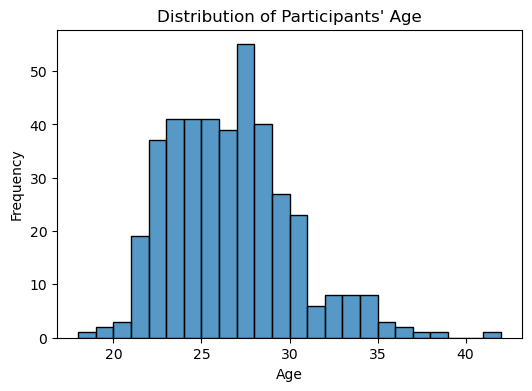

In [15]:
plt.figure(figsize = (6, 4))
sns.histplot(data = subject_df, x = subject_df['age'], binwidth = 1)
plt.title("Distribution of Participants' Age")
plt.xlabel("Age")
plt.ylabel('Frequency')
plt.show()

The mean age of participants was 26.2. The minimum age was 18, and the maximum age was 42. And from the histogram, we could tell there were fewer observations for subjects aged below 20 or above 35. This implies our regression model might not be generalizable to these groups.

### Race

In [16]:
race_mapping = {1: "Black/African American", 
                2: "European/Caucasian-American", 
                3: "Latino/Hispanic American", 
                4: "Asian/Pacific Islander/Asian-American", 
                5: "Native American", 
                6: "Other"}
print(subject_df["race_cd"].map(race_mapping).value_counts())

race_cd
European/Caucasian-American              235
Asian/Pacific Islander/Asian-American     90
Latino/Hispanic American                  33
Other                                     28
Black/African American                    21
Name: count, dtype: int64


Same problem here. Black/African American, Latino/Hispanic American, and international students were underrepresented compared to European/Caucasian-American and Asian/Pacific Islander/Asian American participants. This does not necessarily imply the data set is bad. Instead, doing this kind of descriptive statistics enables us to acknowledge the potential lack of generalizability of the models we make for the next phase to certain populations.

### Career and field

In [17]:
field_mapping = {1: "Law", 2: "Math", 3: "Social Science, Psychologist", 
                 4: "Medical Science, Pharmaceuticals, and Bio Tech", 
                 5: "Engineering", 
                 6: "English/Creative Writing/Journalism", 
                 7: "History/Religion/Philosophy", 
                 8: "Business/Econ/Finance", 
                 9: "Education, Academia", 
                 10: "Biological Sciences/Chemistry/Physics", 
                 11: "Social Work", 12: "Undergrad/undecided", 
                 13: "Political Science/International Affairs", 14: "Film", 
                 15: "Fine Arts/Arts Administration", 16: "Languages", 
                 17: "Architecture", 18: "Other"}

career_mapping = {1: "Lawyer ", 2: "Academic/Research", 
                  3: "Psychologist", 4: "Doctor/Medicine",
                  5: "Engineer", 6: "Creative Arts/Entertainment", 
                  7: "Banking/Consulting/Finance/Marketing/Business", 
                  8: "Real Estate", 
                  9: "International/Humanitarian Affairs", 
                  10: "Undecided", 11: "Social Work", 
                  12: "Speech Pathology", 13: "Politics", 
                  14: "Pro sports/Athletics", 
                  15: "Other", 16: "Journalism", 17: "Architecture"}

# Display in percentages
print(round(subject_df["field_cd"].map(field_mapping).value_counts()/len(subject_df.index),3)*100)
print(round(subject_df["career_cd"].map(career_mapping).value_counts()/len(subject_df.index),3)*100)

field_cd
Business/Econ/Finance                             25.8
Biological Sciences/Chemistry/Physics             11.5
Law                                               10.8
Political Science/International Affairs            9.3
Social Science, Psychologist                       9.1
Engineering                                        7.6
Education, Academia                                6.1
Social Work                                        5.7
History/Religion/Philosophy                        3.4
English/Creative Writing/Journalism                3.4
Math                                               2.2
Medical Science, Pharmaceuticals, and Bio Tech     1.5
Film                                               1.5
Fine Arts/Arts Administration                      0.7
Languages                                          0.7
Undergrad/undecided                                0.2
Architecture                                       0.2
Name: count, dtype: float64
career_cd
Banking/Consulting

The problem of the data regarding participants' fields and careers here was quite obvious. About 1/4 of the participants were in Business/Econ/Finance-related fields and worked for Banking/Consulting/Finance/Marketing/Business. However, majors like Fine Arts/Arts Administration were highly underrepresented. Although we could use field_cd as a predictor, this would not solve the problem with the data itself. Because we could not be confident in whether participants majoring in Fine Arts/Arts Administration could represent the whole population of people majoring in Fine Arts/Arts Administration – we just did not have enough data. Regarding careers, people working in real estate, politics, sports, and architecture were underrepresented.

## Backward Stepwise Selection<a name="backward"></a>

In [18]:
training_set = pd.read_csv("training.csv")
test_set = pd.read_csv("test.csv")
X_full = ['rate_p_attr', 'rate_p_intel', 'rate_p_fun', 'rate_p_amb', 'rate_p_sinc', 'prob',
          'gender_p_attr', 'gender_p_intel', 'gender_p_fun', 'gender_p_amb', 'gender_p_sinc', 'gender_prob']

In [19]:
def eval(y_pred, y_actual):
    # Calculate accuracy, weighted by 1/num_dates
    accuracy = accuracy_score(y_pred, y_actual, sample_weight=test_set['weight'])
    return(round(accuracy,3)*100)

In [20]:
num_rows = 13

data = {'no_of_predictors': [0] * num_rows,
        'predictors': [''] * num_rows,
        'test_accuracy': [0.0] * num_rows}
summary_df = pd.DataFrame(data)
summary_df = summary_df.astype('object')

In [21]:
def backward(X_vars):
    formula = "decision~"
    for var in X_vars:
        formula = formula + var + "+"
    formula = formula[:-1]

    glm = smf.glm(formula,
              data=training_set, 
              family=sm.families.Binomial(),
              freq_weights=training_set['weight'])
    model = glm.fit()
    print(model.summary())
    test_accuracy = eval(model.predict(test_set) > 0.5, test_set['decision'])
    summary_df.iloc[12-len(X_vars), 0] = len(X_vars)
    summary_df.iloc[12-len(X_vars), 1] = formula[9:]
    summary_df.iloc[12-len(X_vars), 2] = test_accuracy

### Full model (12 predictors)

In [22]:
backward(X_full)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               decision   No. Observations:                 4125
Model:                            GLM   Df Residuals:                   257.74
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -135.29
Date:                Mon, 04 Dec 2023   Deviance:                       270.58
Time:                        22:36:18   Pearson chi2:                     275.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02437
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -5.9374      1.049     -5.

### 11-predictor model

Drop gender_p_amb and refit the model.

In [23]:
X11 = X_full
X11.remove('gender_p_amb')
backward(X11)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               decision   No. Observations:                 4125
Model:                            GLM   Df Residuals:                   258.74
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -135.30
Date:                Mon, 04 Dec 2023   Deviance:                       270.60
Time:                        22:36:29   Pearson chi2:                     275.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02437
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -5.9376      1.049     -5.

### 10-predictor model

Drop gender_p_fun and refit the model.

In [24]:
X10 = X11
X10.remove('gender_p_fun')
backward(X10)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               decision   No. Observations:                 4125
Model:                            GLM   Df Residuals:                   259.74
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -135.33
Date:                Mon, 04 Dec 2023   Deviance:                       270.66
Time:                        22:36:39   Pearson chi2:                     275.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02435
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -5.9407      1.049     -5.

### 9-predictor model

Drop rate_p_sinc and refit the model.

In [25]:
X9 = X10
X9.remove('rate_p_sinc')
backward(X9)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               decision   No. Observations:                 4125
Model:                            GLM   Df Residuals:                   260.74
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -135.38
Date:                Mon, 04 Dec 2023   Deviance:                       270.75
Time:                        22:36:50   Pearson chi2:                     275.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02433
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -5.9658      1.046     -5.

### 8-predictor model

Drop gender_p_intel and refit the model.

In [26]:
X8 = X9
X8.remove('gender_p_intel')
backward(X8)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               decision   No. Observations:                 4125
Model:                            GLM   Df Residuals:                   261.74
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -135.55
Date:                Mon, 04 Dec 2023   Deviance:                       271.10
Time:                        22:36:59   Pearson chi2:                     275.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02425
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -5.8822      1.032     -5.698

### 7-predictor model

Drop rate_p_intel and refit the model.

In [27]:
X7 = X8
X7.remove('rate_p_intel')
backward(X7)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               decision   No. Observations:                 4125
Model:                            GLM   Df Residuals:                   262.74
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -135.67
Date:                Mon, 04 Dec 2023   Deviance:                       271.34
Time:                        22:37:08   Pearson chi2:                     278.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02419
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -5.6832      0.944     -6.020

### 6-predictor model

Drop gender_prob and refit the model.

In [28]:
X6 = X7
X6.remove('gender_prob')
backward(X6)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               decision   No. Observations:                 4125
Model:                            GLM   Df Residuals:                   263.74
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -135.84
Date:                Mon, 04 Dec 2023   Deviance:                       271.68
Time:                        22:37:19   Pearson chi2:                     276.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02411
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -5.7479      0.939     -6.123

### 5-predictor model

Drop rate_p_amb and refit the model.

In [29]:
X5 = X6
X5.remove('rate_p_amb')
backward(X5)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               decision   No. Observations:                 4125
Model:                            GLM   Df Residuals:                   264.74
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -136.44
Date:                Mon, 04 Dec 2023   Deviance:                       272.87
Time:                        22:37:25   Pearson chi2:                     277.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02383
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -6.0930      0.891     -6.836

Now all the coefficients have p-value < 0.1. So we stop here and output summary_df.

In [30]:
summary_df.iloc[:8].to_csv("summary.csv", index=False)